# Corrective RAG (CRAG)

In [137]:
# %pip install -r "../requirements.txt"

In [138]:
from dotenv import load_dotenv

load_dotenv()

from knowledge_base import retriever
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.documents.base import Document
from langgraph.graph import StateGraph, MessagesState
from typing import Literal
from pydantic import BaseModel, Field
from langchain.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

## Tool definition

In [139]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_docs",
    "Search and return information about inventory invoices",
)

### Nodes

In [140]:
from langgraph.types import Command


class RouterLLMResponse(BaseModel):
    is_related: bool = Field(description='Classification of the user question, whether it is related to inventory management or not')
    answer: str = Field(description='Answer for the user question')

router_llm_instructions: str = """You are an expert Classification assistant. From the given user query, classify if it is related to inventory management or not If it is not related, give a straight up answer for the question.
Question: {question}
"""

def router_node(state: MessagesState) -> Command[str]:
    llm = ChatGoogleGenerativeAI(model='gemini-2.5-pro', temperature=0)
    response = (
        llm
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

### Question rewriter for better retrieval

In [141]:
class ReWriterLLMResponse(BaseModel):
    """Updated Rewritten Question Model"""
    updated_question: str = Field(description='Updated Question')

question_rewriter_instructions: str = """
You are a helpful question rewriter. The rewritten question will be used to retrieve documents from a vector store.
Current question: {question}
"""

def re_write_question(state: MessagesState) -> dict[str, str]:
    """Question rewriting for better retrieval"""
    messages = state["messages"]
    question = messages[0].content
    llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite', temperature=0)
    res: ReWriterLLMResponse = llm.with_structured_output(ReWriterLLMResponse).invoke(question_rewriter_instructions.format(question))
    return {"messages": [HumanMessage(content=res.updated_question)]}

### Grade docs

In [142]:
class GraderResponse(BaseModel):
    """Response of an Grader assistant that gives a confidence score of a given user question to the given document content"""
    confidence: float = Field(
        description='Confidence score of the document with relevance to user question',
        le=1.0,
        ge=0.0
    )

In [143]:
def grader_node(state: MessagesState) -> Literal['re_write_question', 'generate_answer']:
    router_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash', temperature=0)
    grader =  router_llm.with_structured_output(GraderResponse)
    question = state["messages"][0].content
    context = state["messages"][-1].content
    res = grader.invoke([{
            'role': 'user',
            'content': f"""
    You are an expert Grader assistant. From the given user query, grade the given document content. The scores can range from 0.0 to 1.0. 
    0.0 being no confidence and 1.0 being fully confident.

    Question: {question}
    Document: {context}
    """}])
    if res.confidence > 0.8:
        return 'generate_answer'
    
    return 're_write_question'

### Generate answer node

In [144]:
def generate_answer(state: MessagesState):
    llm = ChatGoogleGenerativeAI(model='gemini-2.5-pro', temperature=0)
    question = state["messages"][0].content
    context = state["messages"][-1].content
    res = llm.invoke(f"""
You are a helpful Clerical assistant. For the given user question and supporting documents, generate a response.

< Answer >
Respond to the user question in a friendly manner.
let the user know you have searched for the files and found the most appropriate information:

Question: {question}
Context: {context}
Answer: ?
</Answer>
""")
    return {"messages": [res]}

## Graph

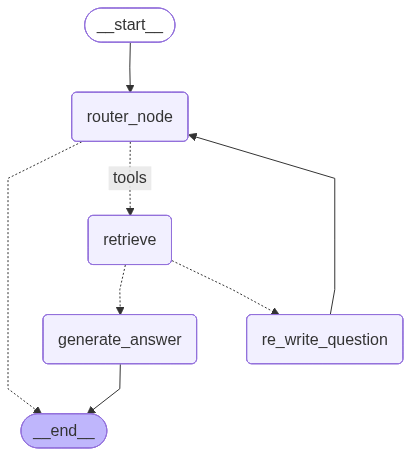

In [145]:

workflow = StateGraph(MessagesState)

workflow.add_node(router_node)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(re_write_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "router_node")

workflow.add_conditional_edges(
    "router_node",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grader_node,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("re_write_question", "router_node")

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Tests

In [146]:
def ask_ai(q):
    for chunk in graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": q,
                }
            ]
        }
    ):
        for node, update in chunk.items():
            print("Update from node", node)
            update["messages"][-1].pretty_print()
            print("\n\n")

In [147]:
ask_ai('who purchased bluray')

Update from node router_node
================================== Ai Message ==================================
Tool Calls:
  retrieve_docs (daf40354-8131-48d6-9770-8aee4a622eda)
 Call ID: daf40354-8131-48d6-9770-8aee4a622eda
  Args:
    query: who purchased bluray



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_docs

INVOICE
# 40100
SuperStore
Bill To
:
Aaron Hawkins
Ship To
:
10035, New York City,
New York, United
States
Dec 30 2012
First Class
$112.53
Date
:
Ship Mode
:
Balance Due
:
Item
Quantity
Rate
Amount
Verbatim 25 GB 6x Blu-ray Single Layer Recordable Disc, 10/Pack
3
$34.77
$104.31
Accessories, Technology, TEC-AC-6340
$104.31
$8.22
$112.53
Subtotal
:
Shipping
:
Total
:
Notes
:
Thanks for your business!
Terms
:
Order ID : CA-2012-AH10030140-41273

INVOICE
Bill To
:
Jun 5, 2023
$0.00
Date
:
Balance Due
:
Item
Quantity
Rate
Amount
$0.00
Total
:

INVOICE
# 28215
SuperStore
Bill To
:
Tracy Blumstein
Ship To

In [148]:
ask_ai('hey')

Update from node router_node
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Hello! How can I help you today?', 'extras': {'signature': 'CqoBAdHtim/XVf+JlH1VtfulLd/7o030GQwtRc3XsmS/vRdrSplbigmD3+UtSpJ7Pe7dzhkA8WbIEN1BR8XvLJtNuAx9r3eewvSkhmlR7KyMi9TajrFZUFpFh/jJkbNViaQ0GbPzmkUpCLrnDzK3x5kvR7nRNAK7NK1Pqtt0+HO+fE749RD8648Fy8QzjvF+I6TTO7qBmvypwBotKBSBVGantG2bX7OUhkDcDZc='}}]





In [149]:
ask_ai('what did Aaron Hawkins purchase?')

Update from node router_node
================================== Ai Message ==================================
Tool Calls:
  retrieve_docs (562948e8-9930-4c53-9fc0-648940a48715)
 Call ID: 562948e8-9930-4c53-9fc0-648940a48715
  Args:
    query: Aaron Hawkins



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_docs

INVOICE
# 38460
SuperStore
Bill To
:
Aaron Hawkins
Ship To
:
12180, Troy, New
York, United States
Apr 21 2012
Second Class
$2,037.92
Date
:
Ship Mode
:
Balance Due
:
Item
Quantity
Rate
Amount
Staples
8
$247.84
$1,982.72
Fasteners, Office Supplies, OFF-FA-6129
$1,982.72
$55.20
$2,037.92
Subtotal
:
Shipping
:
Total
:
Notes
:
Thanks for your business!
Terms
:
Order ID : CA-2012-AH10030140-41020

INVOICE
# 49674
SuperStore
Bill To
:
Aaron Hawkins
Ship To
:
Kryvyy Rih,
Dnipropetrovs'k,
Ukraine
Feb 20 2013
First Class
$8,376.32
Date
:
Ship Mode
:
Balance Due
:
Item
Quantity
Rate
Amount
Hon Rocking Chair, Black
